# CamVid

* UNet with MobileNetV2 & EfficientNet as encoder, with symmetrical decoder.
* Effect of bayesian inference

# Install & Import

In [1]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 5.0 MB/s eta 0:00:00


In [2]:
import sys
import os
import copy
import random
import json
import math
from collections import OrderedDict
from dataclasses import dataclass
from functools import partial
from datetime import date
from prettytable import PrettyTable
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim, Tensor, ones_like, zeros_like
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import torchvision
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from torchvision.datasets import VOCSegmentation
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torchsummary import summary

from typing import Any, Callable, List, Optional, Sequence, Tuple, Union
# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cuda:0


In [86]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

module_dir = "/content/drive/My Drive/ShorelineNet_pytorch/"

# append local module to path
module_path = os.path.abspath(os.path.join(module_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

Mounted at /content/drive/


In [87]:
from model.Bayesian_net import Bayesian_net
from model._Unet import _Unet
from model.MBConfig import MBConvConfig

from utils.bayes_func import bayes_eval, bayes_forward
from utils.train_transforms import HFlip, HueSatCon, Rotation, Crop, Affine, Resize, ToTensor, Normalize

# Archived

### Pascal VOC 2012

Training set: 1464

Validation set: 1449

Testing set is not available and only evaluated through submission

In [5]:
# if 'data' not in os.listdir('/content/'):
#   !mkdir '/content/data/'
#   !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/VOCtrainval_11-May-2012.tar' '/content/data/'

# download_dataset = 'VOCdevkit' not in os.listdir('/content/data/')

# train_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
#                                                      year="2012",
#                                                      image_set="train",
#                                                      download=download_dataset)

# val_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
#                                                      year="2012",
#                                                      image_set="val",
#                                                      download=download_dataset)

# # test_dataset = torchvision.datasets.VOCSegmentation(root="/content/data",
# #                                                      year="2007",
# #                                                      image_set="test",
# #                                                      download=download_dataset)

# print(f'Training set length: {train_dataset}')
# print(f'Validation set length: {val_dataset}')
# # print(f'Test set length: {test_dataset}')

In [6]:
# Global variables (PASCAL VOC 2012)
# CLASSES = [
#   "background",
#   "aeroplane",
#   "bicycle",
#   "bird",
#   "boat",
#   "bottle",
#   "bus",
#   "car",
#   "cat",
#   "chair",
#   "cow",
#   "diningtable",
#   "dog",
#   "horse",
#   "motorbike",
#   "person",
#   "pottedplant",
#   "sheep",
#   "sofa",
#   "train",
#   "tvmonitor",
# ]

# # dummy pixel (placed at boundaries)
# DROP_PIX = 255
# FILL_PIX = 21

# CLASS_MAP_ALL = {i: v for (i, v) in enumerate(CLASSES)}
# CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
# CLASS_MAP_ALL[FILL_PIX] = 'ambiguous'

# NUM_CLASSES = len(CLASS_MAP.keys())
# SEED = 0


In [7]:
# METHODS FOR PASCAL
# def load_pascal_into_memory(dataset:Dataset, t)->MemoryDataset:
#     n = len(dataset)
#     # preallocate tensor memory
#     X = torch.zeros((n, 3, 256, 256), dtype=torch.float32, device=DEVICE, requires_grad=False)
#     Y = torch.zeros((n, 1, 256, 256), dtype=torch.float32, device=DEVICE, requires_grad=False)

#     to_tensor = transforms.PILToTensor()
#     resize_x = transforms.Resize((256, 256), transforms.InterpolationMode.BILINEAR, antialias=True)
#     resize_y = transforms.Resize((256, 256), transforms.InterpolationMode.NEAREST, antialias=False)

#     for i in tqdm(range(n)):
#       x, y = dataset[i]

#       x = to_tensor(x).to(torch.float).to(DEVICE)
#       y = to_tensor(y).to(torch.float).to(DEVICE)

#       x = resize_x(x)
#       y = resize_y(y)

#       x = x / 255.0
#       y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

#       X[i] = x
#       Y[i] = y

#     return MemoryDataset(X, Y, t)


# def get_pascal_train_dataset(transforms) -> Dataset:
#     download_dataset = 'data' not in os.listdir('/content/')

#     train_dataset = VOCSegmentation(root="/content/data",
#                                     year="2012",
#                                     image_set="train",
#                                     download=download_dataset)
#     return load_pascal_into_memory(train_dataset, transforms)

# def get_pascal_val_dataset(transforms) -> Dataset:
#     download_dataset = 'data' not in os.listdir('/content/')

#     val_dataset = VOCSegmentation(root="/content/data",
#                                   year="2012",
#                                   image_set="val",
#                                   download=download_dataset)
#     return load_pascal_into_memory(val_dataset, transforms)

# def color_map(N=256, normalized=False):
#     def bitget(byteval, idx):
#         return ((byteval & (1 << idx)) != 0)

#     dtype = 'float32' if normalized else 'uint8'
#     cmap = np.zeros((N, 3), dtype=dtype)
#     for i in range(N):
#         r = g = b = 0
#         c = i
#         for j in range(8):
#             r = r | (bitget(c, 0) << 7-j)
#             g = g | (bitget(c, 1) << 7-j)
#             b = b | (bitget(c, 2) << 7-j)
#             c = c >> 3

#         cmap[i] = np.array([r, g, b])

#     cmap = cmap/255 if normalized else cmap
#     cmap = cmap/255
#     return cmap

# voc_cmap = ListedColormap(color_map())

### Cityscapes

Has to be loaded from google drive - dataset is 11GB

Abandoned because image resolution is too high & not a practical scope

In [8]:
# !mkdir '/content/data'
# !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/leftImg8bit_trainvaltest.zip' '/content/data/'
# !unzip '/content/data/leftImg8bit_trainvaltest.zip'

# !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/gtFine_trainvaltest.zip' '/content/data/'
# !unzip '/content/data/gtFine_trainvaltest.zip'

# train_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                                 split='train',
#                                                 mode='fine',
#                                                 target_type='semantic')


# val_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                               split='val',
#                                               mode='fine',
#                                               target_type='semantic')

# test_dataset = torchvision.datasets.Cityscapes(root="/content",
#                                               split='test',
#                                               mode='fine',
#                                               target_type='semantic')


# print(f'Train dataset: {len(train_dataset)}')
# print(f'Val dataset: {len(val_dataset)}')
# print(f'Test dataset: {len(test_dataset)}')

# split = val_dataset

# id = np.random.randint(1, len(split))

# plt.figure(figsize=(8, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(split[id][0])
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(split[id][1])
# plt.axis('off')

# Datasets



## CamVid

In [9]:
if 'CamVid' not in os.listdir('/content'):
  !mkdir '/content/data'
  !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/camvid.zip' '/content/data/'
  !unzip -q '/content/data/camvid.zip'

## Define some Global Variables

In [10]:
# get classes for CamVid

# class_dict = pd.read_csv('/content/CamVid/class_dict.csv')

RGB2CLSNAME = {
    (128, 128, 128): "Sky",

    (0, 128, 64): "Building",
    (128, 0, 0): "Building",
    (64, 192, 0): "Building",
    (64, 0, 64): "Building",
    (192, 0, 128): "Building",

    (192, 192, 128): "Pole",
    (0, 0, 64): "Pole",

    (128, 64, 128): "Road",
    (128, 0, 192): "Road",
    (192, 0, 64): "Road",

    (0, 0, 192): "Sidewalk",
    (64, 192, 128): "Sidewalk",
    (128, 128, 192): "Sidewalk",

    (128, 128, 0): "Tree",
    (192, 192, 0): "Tree",

    (192, 128, 128): "SignSymbol",
    (128, 128, 64): "SignSymbol",
    (0, 64, 64): "SignSymbol",

    (64, 64, 128): "Fence",

    (64, 0, 128): "Car",
    (64, 128, 192): "Car",
    (192, 128, 192): "Car",
    (192, 64, 128): "Car",
    (128, 64, 64): "Car",

    (64, 64, 0): "Pedestrian",
    (192, 128, 64): "Pedestrian",
    (64, 0, 192): "Pedestrian",
    (64, 128, 64): "Pedestrian",

    (0, 128, 192): "Bicyclist",
    (192, 0, 192): "Bicyclist",

    (0, 0, 0): "Void"
}


DROP_PIX: Optional[int] = None
FILL_PIX = 11

WIDTH = 480
HEIGHT = 360

CLASSES = list(set(RGB2CLSNAME.values()))
RGB2CLASS = {rgb:{c:i for i,c in enumerate(CLASSES)}[name] for (rgb, name) in RGB2CLSNAME.items()}
CLASS2RGB = {c:rgb for (rgb, c) in RGB2CLASS.items()}

CLASS_MAP_ALL={i:c for i,c in enumerate(CLASSES)}
CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
CLASS_MAP.pop(FILL_PIX)
NUM_CLASSES = len(CLASS_MAP.items())


## Transformations

In [11]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t((image, target))
        return image, target

### Training Transforms

Imported from local modules: `Flip`, `HueSatCon`, `Rotation`, `Crop`, `Affine`, `Resize`, `ToTensor`, `Normalize`

### Test set Transforms

In [12]:
# transformations for test set:

class Normalize_test(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        # imageNet Normalize
        self.Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, x):
        x = self.Normalize(x)
        return x

class Resize_test(object):
    def __init__(self, size):
        self.size = size
        self.resize_x = transforms.Resize(size, transforms.InterpolationMode.BILINEAR, antialias=True)

    def __call__(self, x):
        x = self.resize_x(x)
        return x


## Dataset & Dataloader

In [16]:
class MemoryDataset(Dataset):
    def __init__(self,
                 X:Tensor,
                 y:Tensor,
                 transform:Optional[transforms.Compose]=None,
    ) -> None:
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, H, W)
        y : Tensor with shape (n, 1, H, W)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            # x, y = self.transform((x, y))
            x, y = self.transform(x, y) # to be consistent with torch
        return x, y

def get_train_transforms(intensity:float=1) -> transforms.Compose:
    '''
    Returns the transformations for the training set for given intensity
    '''
    z = intensity
    train_transforms = Compose([
      HFlip(prob=0.5),
      HueSatCon(brightness=0.1*z, contrast=0.1*z, saturation=0.1*z, hue=0.1*z, prob=1),
      Affine(affine_percentage=0.1*z, shear_deg=5*z, fill_pix=FILL_PIX, prob=1),
      Rotation(10*z, fill_pix=FILL_PIX, prob=1),
      Crop(crop_percentage=1-z*0.1, prob=1),
      Resize((HEIGHT, WIDTH)),
      # ToTensor(),
      Normalize(),
    ])
    return train_transforms


class DatasetManager():
  '''
  Holds dataset objects in a dict and manages augmentation properties for training set
  '''
  def __init__(self, intensity: Optional[float]=1) -> None:
    train_transforms = get_train_transforms(intensity=intensity)

    val_transforms = Compose([
        Resize((HEIGHT, WIDTH)),
        # ToTensor(),
        Normalize(),
    ])

    test_transforms = Compose([
        Resize_test((HEIGHT, WIDTH)),
        # ToTensor(),
        Normalize_test()
    ])

    # train_dataset = get_train_dataset(train_transforms)
    # val_dataset = get_val_dataset(val_transforms)

    train_dataset = load_camvid_into_memory('train', train_transforms)
    val_dataset = load_camvid_into_memory('val', val_transforms)
    test_dataset = load_camvid_into_memory('test', val_transforms)

    self.datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

  def update_train_transforms(self, intensity:float=1) -> None:
    train_transforms = get_train_transforms(intensity)
    self.datasets['train'].transforms = train_transforms
    print(f'Updated training dataset augmentation intensity to {intensity}')
    return


In [14]:
# METHODS FOR CAMVID

def load_camvid_into_memory(split:str, t:transforms.Compose)->MemoryDataset:
    root_dir = '/content/CamVid'

    n = len(os.listdir(f'{root_dir}/{split}'))
    # preallocate tensor memory
    X = torch.zeros((n, 3, 480, 640), dtype=torch.float, device=DEVICE, requires_grad=False)
    Y = torch.zeros((n, 1, 480, 640), dtype=torch.float, device=DEVICE, requires_grad=False)

    to_tensor = transforms.PILToTensor()
    resize_x = transforms.Resize((480, 640), transforms.InterpolationMode.BILINEAR, antialias=True)
    resize_y = transforms.Resize((480, 640), transforms.InterpolationMode.NEAREST, antialias=False)

    for i in tqdm(range(n)):
      filename = os.listdir(f'{root_dir}/{split}')[i]
      x_path = os.path.join(root_dir, split, filename)
      y_path = os.path.join(root_dir, f'{split}_labels', filename.split('.')[0]+'_L.png')

      x = read_image(x_path).to(DEVICE)
      y = read_image(y_path).to(DEVICE)

      # x = to_tensor(x).to(torch.int8).to(DEVICE)
      y = map_rgbLabel_to_grayscale(y)

      x = resize_x(x)
      y = resize_y(y)

      x = x / 255.0
      if DROP_PIX is not None:
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      X[i] = x
      Y[i] = y

    return MemoryDataset(X, Y, t)

def map_rgbLabel_to_grayscale(image: np.array) -> torch.Tensor:
    '''
    Takes a (3 x w x h) int8 rgb label and returns a (1 x w x h) label
    '''
    height, width = image.shape[1], image.shape[2]
    out = torch.zeros((1, height, width), dtype=torch.int, device=image.device)

    for (rgb, cls) in RGB2CLASS.items():
      boolean_array = (image[0] == rgb[0])
      boolean_array = boolean_array * (image[1] == rgb[1])
      boolean_array = boolean_array * (image[2] == rgb[2])
      out[0, boolean_array] = cls

    return out


In [17]:
# create dataset manager
dataset_manager = DatasetManager()

# create dataloaders
train_dataloader = DataLoader(dataset_manager.datasets['train'], batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_manager.datasets['val'], batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset_manager.datasets['test'], batch_size=1, shuffle=True)

# note that new instances of dataloaders are generated for every training
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

### Visualization helpers

* `imshow_image`
* `imshow_label`
* `imshow_uncertainty`

In [83]:
# helper functions
from matplotlib.colors import ListedColormap
colors = [CLASS2RGB[i] for i in range(NUM_CLASSES+1)]
camvid_cmap = ListedColormap([list([c/255 for c in rgb]) for rgb in colors])

def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

def imshow_image(image):
  plt.imshow(unnormalize(image).permute(1, 2, 0).cpu())

def imshow_label(label, cmap=camvid_cmap):
  if len(label.shape) == 3:
    label = label.permute(1, 2, 0)
  elif len(label.shape) == 2:
    pass
  plt.imshow(label.cpu(), cmap=cmap, interpolation='none', vmin=0, vmax=NUM_CLASSES)

def imshow_uncertainty(uncertainty: Tensor):
  if len(uncertainty.shape) == 3:
    uncertainty = uncertainty.permute(1, 2, 0)
  # TODO: normalize to 0 - 1?
  plt.imshow(uncertainty.cpu())

### Preview images

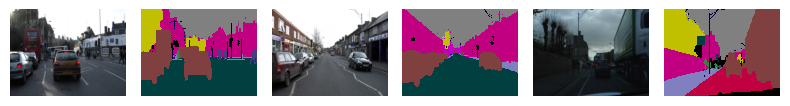

In [19]:
split = 'test'

plt.figure(figsize=(8, 4))
for i in range(3):
  x_batch_sample, y_batch_sample = next(iter(dataloaders[split]))
  plt.subplot(1, 6, i*2+1)
  imshow_image(x_batch_sample[0])
  plt.axis('off')
  plt.subplot(1, 6, i*2+2)
  imshow_label(y_batch_sample[0].to(int))
  plt.axis('off')

# note: clipping error message can be ignored
plt.tight_layout()

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

In [20]:
# helper functions for counting parameters and storage
def count_parameters(model, showTable=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if showTable:
        print(table)
    return total_params


def calculate_storage(model, show_buffer=True):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    if show_buffer:
        print(f"Buffer size: {buffer_size/1024**2:.3f} MB")

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb


## UNet

### Network Config
Configuration for efficientnet and mobilenet

In [21]:
def _efficientnet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 5, 2, 24, 40, 2, 0, 1),
        bneck_conf(6, 3, 2, 40, 80, 3, 0, 0),
        bneck_conf(6, 5, 1, 80, 112, 3, 0.5, 1),
        bneck_conf(6, 5, 2, 112, 192, 4, 0.5, 0),
        bneck_conf(6, 3, 1, 192, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting


def _mobilenet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 3, 2, 24, 32, 3, 0, 1),
        bneck_conf(6, 3, 2, 32, 64, 4, 0, 0),
        bneck_conf(6, 3, 1, 64, 96, 3, 0.5, 1),
        bneck_conf(6, 3, 2, 96, 160, 3, 0.5, 0),
        bneck_conf(6, 3, 1, 160, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting

# scaling factors and input dimensions
efficient_nets = {
    "efficientnet-b0": (1.0, 1.0, 224),
    "efficientnet-b1": (1.0, 1.1, 240),
    "efficientnet-b2": (1.1, 1.2, 260),
    "efficientnet-b3": (1.2, 1.4, 300),
    "efficientnet-b4": (1.4, 1.8, 380),
    "efficientnet-b5": (1.6, 2.2, 456),
    "efficientnet-b6": (1.8, 2.6, 528),
    "efficientnet-b7": (2.0, 3.1, 600),
}

mobile_nets = {"mobilenet-v2": (1.0, 1.0, 224)}

### Unet

Wrapper class for building the network for a given configuration


In [85]:
class Unet(_Unet):
    def __init__(
        self,
        encoder_name: str = "efficientnet-b0",
        input_dim: Optional[Union[int, Tuple[int, int]]] = None,
        stochastic_depth_prob: float = 0.2,
        dropout_p: float = 0.5,
        num_classes: int = 3,
        last_channel: Optional[int] = None, # set 0 to disable, None for auto
        constant_dropout: Optional[bool] = True,
    )->None:
        if encoder_name.startswith("efficientnet"):
            width_mult = efficient_nets[encoder_name][0]
            depth_mult = efficient_nets[encoder_name][1]
            d = efficient_nets[encoder_name][2] if not input_dim else input_dim
            use_se = True
            activation_layer = nn.SiLU
            cfg = _efficientnet_cfg(width_mult, depth_mult)
        elif encoder_name.startswith("mobilenet"):
            width_mult = mobile_nets[encoder_name][0]
            depth_mult = mobile_nets[encoder_name][1]
            d = mobile_nets[encoder_name][2] if not input_dim else input_dim
            use_se = False
            activation_layer = nn.ReLU
            stochastic_depth_prob = 0.0
            cfg = _mobilenet_cfg(width_mult, depth_mult)
        else:
            raise NotImplementedError

        for i in range(len(cfg)):
            if constant_dropout:
                cfg[i].dropout_p = dropout_p if cfg[i].dropout_p > 0 else 0
            else:
                # linearly interpolate the dropout rate
                cfg[i].dropout_p = dropout_p * float(i) / (len(cfg) - 1)

        super().__init__(
            cfg,
            d,
            stochastic_depth_prob,
            num_classes,
            last_channel=last_channel,
            use_se=use_se,
            activation_layer=activation_layer,
        )

## network instantiation

In [89]:
# net_name = "mobilenet-v2"
net_name = "efficientnet-b0"

net = Unet(net_name,
           input_dim=(HEIGHT, WIDTH),
           dropout_p=0.5,
           constant_dropout=False,
           stochastic_depth_prob=0.2,
           last_channel=0,
           num_classes=NUM_CLASSES)

print("----UNET----")
size_all_mb = calculate_storage(net)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net)
print(f"Total Trainable Params: {total_params/1e6 :.3f}M")

net.to(DEVICE)
print(f'moved network to {DEVICE}')

----UNET----
Buffer size: 0.315 MB
model size: 30.651MB
Total Trainable Params: 7.952M
moved network to cuda:0


### Dummy pass to see initial outputs

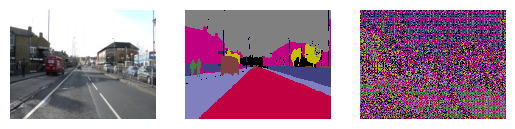

In [24]:
x_batch_sample, y_batch_sample = next(iter(test_dataloader))

net = net
# net = training_manager.net

with torch.no_grad():
  net.eval()
  net.set_bayes_mode(False, 'all')
  plt.subplot(1, 3, 1)
  plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
  plt.axis('off')

  plt.subplot(1, 3, 2)
  imshow_label(y_batch_sample[0])
  plt.axis('off')
  net.train()

  pred = net(x_batch_sample.to(DEVICE))
  plt.subplot(1, 3, 3)
  imshow_label(torch.argmax(pred[0], dim=0))
  plt.axis('off')
  net.train()

In [25]:
del(net)

## Loss

In [26]:
class FocalLoss(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    # place mask over placeholder pixels (loss do not propagate through them)
    mask = torch.where(y_true == FILL_PIX, zeros_like(y_true), ones_like(y_true))

    y_true = (y_true * mask).squeeze(dim=1)
    # one-hot encode labels
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=NUM_CLASSES).float().permute(0, 3, 1, 2)

    y_pred = y_pred * mask
    focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (focal_loss * mask).sum() / (mask.sum()+1e-16)

    return loss

class CELoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=FILL_PIX, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    return loss


## Metric

In [27]:
# TODO: DICE accuracy

### Raw pixel accuracy

In [28]:
class AccuracyMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax)->dict:
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class, avg, and global accuracies
    '''
    metrics = {}

    ious = self.iou(y_pred_softmax, y_true.squeeze(dim=1))
    for i, c in CLASS_MAP.items():
      metrics[f'iou/{c}'] = ious[i]
    metrics['iou/mean'] = ious.mean()

    # select most probable class
    y_pred = torch.argmax(y_pred_softmax, 1, keepdim=True)

    # compute per-class accuracy
    for i, c in CLASS_MAP.items():
      # filter gt pixels for class c
      correct_pixels = (y_true == i) * (y_pred == y_true)
      # index by the class name
      metrics[f'acc/{c}'] = correct_pixels.sum()/((y_true == i).sum() + 1e-16)

    # compute average per-class accuracy
    avg_accuracy = 0
    for a in metrics.values():
      avg_accuracy += a
    metrics['acc/avg'] = avg_accuracy / len(metrics.values())

    # compute global accuracy
    mask = y_true != FILL_PIX # binary mask
    # correct pixels
    diff = y_pred == y_true
    # filter
    metrics['acc/global'] = (diff*mask).sum() / mask.sum()

    return metrics


### IOU

In [29]:
class IOUMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class and mean IOUs
    '''
    out = {}
    ious = self.iou(y_pred_softmax, y_true)
    for i, c in CLASS_MAP.items():
      out[c] = ious[i]
    out['mean'] = ious.mean()
    return out

# Bayesian Functions

## Bayes Forward
Imported from local modules

    Performs k forward passes with stochastic regularisation

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor (k x c x W x H) buffer

    Returns
    -----------
    y_logits             : torch.tensor (c x W x H)
    y_pred               : torch.tensor (W x H)
    y_pred_std_per_class : torch.tensor (c x W x H)
    y_pred_std_avg       : torch.tensor (W x H)


## Bayes Evaluation Pass

Only outputs the final predictions, used for inference on test set & saves some computation

    Performs k forward passes with dropout layers, returns prediction

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor(k x c x W x H) buffer

    Returns
    -----------
    y_pred               : torch.tensor (W x H)

## Calibration

In [30]:
def plot_calibration(net, dataloader, ks=[0, 5, 10], num_buckets = 10):
  x_axis = np.array(range(num_buckets)) / num_buckets
  linear_line = np.array(range(num_buckets+1)) / (num_buckets+1)

  plt.figure(figsize=(8, 6))
  plt.plot(linear_line, linear_line, color='black', zorder=2)
  for i, k in enumerate(ks):
    buckets = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)
    # plt.subplot(1, 3, i+1)
    # plt.bar(x_axis, buckets, width=0.5, align='edge')
    plt.plot(x_axis, buckets, label=f'k={k}')
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  plt.legend()


def get_calibration(net,
                    dataloader,
                    k:int,
                    mode: Optional[str]='all',
                    num_buckets:Optional[int]=10):
  '''
  Plots reliability graph for the network

  Args
  -----------
  net: nn.Module
  dataloader: torch.Dataloader
  k: set to 0 for regular forward pass, or larger than 0 for bayes forward pass
  mode: sets the mode of which bayesian inference to perform
  num_buckets: number of buckets to separate between 0 to 100 probabiliy

  '''
  total_counts = np.array([1e-16]*num_buckets)
  total_corrects = np.array([0]*num_buckets)

  # loop through images and make predictions
  for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        net.eval()
        # bayes forward pass
        if k == 0:
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).squeeze(dim=0)
        elif k > 0:
          net.set_bayes_mode(True, mode)
          y_softmax, _, _, _ = bayes_forward(net, x, k)

        counts, corrects = get_calibration_per_prediction(y, y_softmax, num_buckets)
        total_counts += counts
        total_corrects += corrects

  buckets = total_corrects / total_counts

  return buckets

def get_calibration_per_prediction(y_gt, y_softmax, num_buckets):
  '''
  Computes reliability values for each image

  Args
  -----------
  y_gt: torch.tensor (1 x W x H)
  y_softmax: torch.tensor (c x W x H)
  num_buckets: int

  Returns
  -----------
  counts: np.array (num_buckets, )
  correct: np.array (num_buckets, )
  '''
  out_count = np.array([0]*num_buckets)
  out_correct = np.array([0]*num_buckets)
  step = 1/num_buckets
  # get probability and prediction
  y_prob, y_pred = torch.max(y_softmax, dim=0)
  indices = y_prob // step

  for i in range(num_buckets):
    out_count[i] += ((indices==i)).sum()
    out_correct[i] += ((indices==i)*(y_pred==y_gt)).sum()

  return out_count, out_correct


## Epistemic & Aleatoric Uncertainties

In [31]:
def compute_bayesian_uncertainties(net, X:Tensor, k:int, mode:Optional[str]='all')->Tuple[Tensor, Tensor]:
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (c x W x H), a single input image
  k  : int, indicating number of repeated forwards passes
  mode: str, indicating what mode of bayesian inference to do

  Returns
  -----------
  aleatoric_uncertainty: torch.tensor (W x H)
  epistemic_uncertainty: torch.tensor (W x H)
  '''
  assert (k>=1)

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, mode)
    # write image to buffer
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
    for i in range(k):
      buffer[i] = X
    y_pred_raw = net(buffer)

    avg_over_k = y_pred_raw.mean(dim=0)
    predictive_entropy = -(avg_over_k * torch.log(avg_over_k)).sum(dim=0)
    mutual_information = predictive_entropy + 1/k * (y_pred_raw*torch.log(y_pred_raw)).sum(dim=0).sum(dim=0)

  net.set_bayes_mode(True, 'all')

  epistemic_uncertainty = mutual_information
  aleatoric_uncertainty = predictive_entropy - epistemic_uncertainty

  return aleatoric_uncertainty, epistemic_uncertainty

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [77]:
class TrainingManager():
  def __init__(self, datasets, config):
    self.datasets = datasets
    self.config = config

    self._load()
    # self.net = copy.deepcopy(net).to(DEVICE) # no longer importing net

  def _load(self):
    # hyperparameters from config
    self.batch_size = self.config.get('batch_size', 16)
    self.weight_decay = self.config.get('weight_decay', 1e-4)
    self.lr = self.config.get('lr', 1e-4)
    self.k = self.config.get('k', 10)
    self.patience = self.config.get('patience', 20)
    self.num_classes = self.config.get('num_classes', 3)
    self.bayes_mode = self.config.get('bayes_mode', 'all')
    self.eval_subset = self.config.get('eval_subset', None)

    # initiate dataloader
    self.dataloaders = {'train': DataLoader(self.datasets['train'], batch_size=self.batch_size, shuffle=True),
                        'val': DataLoader(self.datasets['val'], batch_size=1, shuffle=True),
                        'test': DataLoader(self.datasets['test'], batch_size=1, shuffle=False)}

    # initiate net
    self.net = Unet(self.config['model'],
                    self.config['input_dim'],
                    self.config['stochastic_depth_prob'],
                    self.config['dropout_p'],
                    self.num_classes,
                    constant_dropout = self.config['dropout_mode'] == 'constant')
    self.net.to(DEVICE)
    self.best_net = None

    self.loss_func = self.config.get('loss', 'CE')
    if self.loss_func == 'Focal':
      self.criterion = FocalLoss()
    elif self.loss_func == 'CE':
      self.criterion = CELoss()
    else:
      print('Invalid loss function')
      raise ValueError()

    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)

    self.epoch = 0
    self.early_stop = False
    self.history = {'lr': []}

    for split in ['train', 'val', 'val_b']:
      self.history[f'loss/{split}'] = []
      self.history[f'acc/avg/{split}'] = []
      self.history[f'acc/global/{split}'] = []
      self.history[f'iou/mean/{split}'] = []
      for c in CLASS_MAP.values():
        self.history[f'acc/{c}/{split}'] = []
        self.history[f'iou/{c}/{split}'] = []

    self.history['best_val_loss'] = 999
    self.history['best_epoch'] = 0
    self.patience_count = 0

  def train(self, epochs, eval_mode='bayes'):
    # torch.cuda.empty_cache() # helps clearing RAM
    # self.net.train()
    # self.net.set_bayes_mode(True, net.set_bayes_mode)

    for e in range(epochs):
      self.net.train()
      self.net.set_bayes_mode(True, 'all')
      # create temporary dict to hold epoch results for train set
      train_epoch_logs = {'loss': 0, 'acc/avg': 0, 'acc/global': 0, 'iou/mean': 0}
      for c in CLASS_MAP.values():
        train_epoch_logs[f'acc/{c}'] = 0
        train_epoch_logs[f'iou/{c}'] = 0

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_logits = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_logits)
        accs = self.metric(y_batch, y_logits)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # log batch loss and accuracy
        batch_size = X_batch.shape[0]
        train_epoch_logs['loss'] += loss.item() * batch_size
        for k, v in accs.items():
          train_epoch_logs[k] += v.item() * batch_size

      n_train = len(self.dataloaders['train'].dataset)
      train_epoch_logs = {k:v/n_train for k, v in train_epoch_logs.items()}
      # log epoch loss and accuracy
      for k,v in train_epoch_logs.items():
        self.history[f'{k}/train'].append(v)

      val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode, subset=self.eval_subset)

      self._update_best_net()
      if self.early_stop:
        return

      if val_loss is not None:
        self.history['loss/val'].append(val_loss)
        for name in val_accs.keys():
          self.history[f'{name}/val'].append(val_accs.get(name, 0))

      if val_loss_b is not None:
        self.history['loss/val_b'].append(val_loss_b)
        for name in val_accs_b.keys():
          self.history[f'{name}/val_b'].append(val_accs_b.get(name, 0))

      self.history['lr'].append(float(self._lr()))
      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Train: Acc(g) = {self.history['acc/global/train'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/train'][-1]*100:.4f}, mIOU = {self.history['iou/mean/train'][-1]*100:.4f}, Loss = {self.history['loss/train'][-1]:.4f}")
      print(f"Val: Acc(g) = {self.history['acc/global/val'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/val'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val'][-1]*100:.4f}, Loss = {self.history['loss/val'][-1]:.4f}")
      if eval_mode == 'all' or eval_mode == 'bayes':
        print(f"Bayes_validation: Acc = {self.history['acc/global/val_b'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val_b'][-1]*100:.4f}, Loss = {self.history['loss/val_b'][-1]:.4f}")

  def _lr(self)->float:
    return self.optimizer.param_groups[0]['lr']

  def _set_lr(self, lr:float)->None:
    self.optimizer.param_groups[0]['lr'] = lr

  def _update_best_net(self, min_epochs=10):
    metric = 'loss/val'
    if self.epoch < min_epochs or len(self.history[metric]) <= 1:
      return

    loss = self.history[metric][-1]
    curr_min = self.history['best_val_loss']

    if loss < curr_min:
      print(f'updating best net, loss decreased by {(curr_min-loss)/curr_min*100 :.3f} %')
      self.best_net = copy.deepcopy(self.net)
      self.history['best_val_loss'] = loss
      self.history['best_epoch'] = self.epoch
      self.patience_count = 0
    else:
      self.patience_count += 1
    if self.patience_count >= self.patience:
      if self._lr != 1e-5:
        self._set_lr(self._lr/10)
        print(f'Decrease lr to {self._lr}')
      else:
        print(f'{metric} has not improved for {self.patience} epochs, terminate training')
        self.early_stop = True

  def _evaluate_regular(self,
                        dataloader:DataLoader,
                        net:Optional[nn.Module]=None
  ) -> Tuple[int, dict[str, float]]:
    net = net if net != None else self.net
    net.eval()
    net.set_bayes_mode(False, 'all')
    total_loss = 0
    total_accs = {}
    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_pred = net(X)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)
        total_loss += loss * len(X)

        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc * len(X)

    n = len(dataloader.dataset)
    loss = total_loss.item()/n
    accs = {k: v.item()/n for k, v in total_accs.items()}

    return loss, accs

  def _evaluate_bayes(self, dataloader, k=None, net=None):
    net = net if net != None else self.net

    if k == None:
      k = self.k

    h, w = self.config['input_dim']
    buffer_tensor = torch.empty(size=(k, 3, h, w), dtype=torch.float32, device=DEVICE)

    total_loss = 0
    total_accs = {}
    for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_logits, _, _, _ = bayes_forward(net, x, k, self.bayes_mode, buffer_tensor)
        y_logits = y_logits.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_logits)
        accs = self.metric(y, y_logits)

        total_loss += loss
        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc

    n = len(dataloader.dataset)
    return total_loss.item()/n, {k: v.item()/n for k, v in total_accs.items()}

  def evaluate(self,
               eval_dataset:str='val',
               mode:str='bayes',
               subset:Optional[int]=None
    ) -> Tuple[int, dict, int, dict]:
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all', 'none'])

    temp_dict = {}
    for c in CLASS_MAP.values():
      temp_dict[f'acc/{c}'] = 0
      temp_dict[f'iou/{c}'] = 0
    temp_dict['acc/avg'] = 0
    temp_dict['acc/global'] = 0
    temp_dict['iou/mean'] = 0

    # generate subset
    if not subset:
      dataloader = self.dataloaders[eval_dataset]
    else:
      indices = torch.randperm(len(self.datasets[eval_dataset]))[:subset]
      sub_eval_dataset = torch.utils.data.Subset(self.datasets[eval_dataset], indices)
      dataloader = DataLoader(sub_eval_dataset, batch_size=1, shuffle=True)

    # initiate temporary values
    loss, accs, loss_b, accs_b = 0, temp_dict, 0, temp_dict
    if mode == 'regular':
      loss, accs = self._evaluate_regular(dataloader)
    elif mode == 'bayes':
      loss_b, accs_b = self._evaluate_bayes(dataloader)
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, accs = self._evaluate_regular(dataloader)
      loss_b, accs_b = self._evaluate_bayes(dataloader)
    else:
      return

    return loss, accs, loss_b, accs_b

  # def plot(self, save=False, directory=None):
  #   '''
  #   Plots training history
  #   '''
  #   plt.figure(figsize=(16, 16))

  #   # history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
  #   history = self.history

  #   x = list(range(1, self.epoch+1, 1))
  #   plt.subplot(3, 3, 1)
  #   plt.title('Loss')
  #   plt.plot(x, history['loss/train'], label='train',)
  #   plt.plot(x, history['loss/val'], label='val')
  #   plt.plot(x, history['loss/val_b'], label='val_b')
  #   plt.xlabel('epochs')
  #   plt.ylabel('loss')
  #   plt.legend()

  #   plt.subplot(3, 3, 2)
  #   plt.title('Accuracy(g)')
  #   plt.plot(x, history['acc/global/train'], label='train',)
  #   plt.plot(x, history['acc/global/val'], label='val')
  #   plt.plot(x, history['acc/global/val_b'], label='val_b')
  #   plt.xlabel('epochs')
  #   plt.ylabel('acc')
  #   plt.legend()

  #   # plt.subplot(3, 3, 3)
  #   # plt.title('Accuracy(c)')
  #   # plt.plot(x, history['acc/avg/train'], label='train',)
  #   # plt.plot(x, history['acc/avg/val'], label='val')
  #   # plt.plot(x, history['acc/avg/val_b'], label='val_b')
  #   # plt.xlabel('epochs')
  #   # plt.ylabel('acc')
  #   # plt.legend()

  #   plt.subplot(3, 3, 3)
  #   plt.title('mIOU')
  #   plt.plot(x, history['iou/mean/train'], label='train',)
  #   plt.plot(x, history['iou/mean/val'], label='val')
  #   plt.plot(x, history['iou/mean/val_b'], label='val_b')
  #   plt.xlabel('epochs')
  #   plt.ylabel('iou')
  #   plt.legend()

  #   for i in range(3):
  #     plt.subplot(3, 3, 4+i)
  #     c_name = CLASS_MAP[i]
  #     plt.title(f'Accuracy({c_name})')
  #     # plt.plot(x, history[f'acc/{c_name}/train'], label='train',)
  #     plt.plot(x, history[f'acc/{c_name}/val'], label='val')
  #     plt.plot(x, history[f'acc/{c_name}/val_b'], label='val_b')
  #     plt.xlabel('epochs')
  #     plt.ylabel('acc')
  #     plt.legend()

  #   for i in range(3):
  #     plt.subplot(3, 3, 7+i)
  #     c_name = CLASS_MAP[i]
  #     plt.title(f'IOU({c_name})')
  #     plt.plot(x, history[f'iou/{c_name}/val'], label='val')
  #     plt.plot(x, history[f'iou/{c_name}/val_b'], label='val_b')
  #     plt.xlabel('epochs')
  #     plt.ylabel('iou')
  #     plt.legend()

  #   if save:
  #     plt.savefig(os.path.join(directory, 'history.png'), dpi=200)
  #   else:
  #     plt.show()

  #   return

  # def plot_acc_vs_k(self, ks=[1, 3, 5, 10, 15, 20, 25, 30, 35, 40], dataloader=None, num_repeats=5, save_to_dir=None, net=None):
  #   '''
  #   plots accuracy vs k
  #   '''
  #   if dataloader is None:
  #     dataloader = self.dataloaders['val']

  #   # evaluate bayesian forward for different ks
  #   losses, accs_g, accs_a, mious = [], [], [], []
  #   losses_std, accs_g_std, accs_a_std, mious_std = [], [], [], []
  #   print('evaluating...')

  #   # weight averaging (i.e. regular)
  #   wa_loss, wa_accs = self._evaluate_regular(dataloader, net)

  #   for k in tqdm(ks):
  #     loss, acc_g, acc_a, miou = [], [], [], []
  #     for i in range(num_repeats):
  #       l, a = self._evaluate_bayes(dataloader, k, net)
  #       loss.append(l)
  #       acc_g.append(a['acc/global'])
  #       acc_a.append(a['acc/avg'])
  #       miou.append(a['iou/mean'])
  #     loss, acc_g, acc_a, miou = np.array(loss), np.array(acc_g), np.array(acc_a), np.array(miou)
  #     losses.append(loss.mean())
  #     losses_std.append(loss.std())
  #     accs_g.append(acc_g.mean())
  #     accs_g_std.append(acc_g.std())
  #     accs_a.append(acc_a.mean())
  #     accs_a_std.append(acc_a.std())
  #     mious.append(miou.mean())
  #     mious_std.append(miou.std())

  #     # print(f'{k}: {loss}, {accs['global']}, {accs['avg']}')


  #   plt.figure(figsize=(20, 5))
  #   plt.subplot(1, 4, 1)
  #   plt.title('Loss')
  #   plt.errorbar(ks, losses, yerr=losses_std, label='Bayes')
  #   plt.plot(ks, [wa_loss]*len(ks), label='WA')
  #   plt.legend()

  #   plt.subplot(1, 4, 2)
  #   plt.title('Acc(g)')
  #   plt.errorbar(ks, accs_g, yerr=accs_g_std, label='Bayes')
  #   plt.plot(ks, [wa_accs['acc/global']]*len(ks), label='WA')
  #   plt.legend()

  #   plt.subplot(1, 4, 3)
  #   plt.title('Acc(c)')
  #   plt.errorbar(ks, accs_a, yerr=accs_a_std, label='Bayes')
  #   plt.plot(ks, [wa_accs['acc/avg']]*len(ks), label='WA')
  #   plt.legend()

  #   plt.subplot(1, 4, 4)
  #   plt.title('mIOU')
  #   plt.errorbar(ks, mious, yerr=mious_std, label='Bayes')
  #   plt.plot(ks, [wa_accs['iou/mean']]*len(ks), label='WA')
  #   plt.legend()

  #   if save_to_dir != None:
  #     plt.savefig(os.path.join(save_to_dir, 'acc_v_k.png'), dpi=200)

  #   return

  # def _save_model(self, directory, save_best):
  #   print(f'saving model at {self.epoch} epochs...')
  #   # TODO: save best model (on validation set)
  #   torch.save(self.net.state_dict(), os.path.join(directory, 'model.pt'))
  #   print(f"saving best model at {self.history['best_epoch']} epochs...")
  #   if save_best and self.best_net != None:
  #     torch.save(self.best_net.state_dict(), os.path.join(directory, 'model_best.pt'))
  #   return

  # def _save_history(self, directory):
  #   print('saving history...')
  #   # add date and epoch to history
  #   history = self.history.copy()
  #   history['date'] = str(date.today())
  #   history['epoch'] = self.epoch
  #   filepath = os.path.join(directory, 'history.json')
  #   with open(filepath, "w") as f:
  #     json.dump(history, f)
  #   return

  # def _save_config(self, directory):
  #   print('saving config...')
  #   filepath = os.path.join(directory, 'config.json')
  #   with open(filepath, "w") as f:
  #     json.dump(self.config, f)
  #   return

  # def _save_summary(self, directory):
  #   print('saving summary...')
  #   summary_json = {'WA': {}, 'Bayes': {}}
  #   l, a, l_b, a_b = self.evaluate('test', mode='all')
  #   summary_json['WA']['loss'] = l
  #   summary_json['Bayes']['loss'] = l_b
  #   summary_json['WA']['metrics'] = a
  #   summary_json['WA']['metrics'] = a_b
  #   filepath = os.path.join(directory, 'summary.json')
  #   with open(filepath, "w") as f:
  #     json.dump(summary_json, f)
  #   return


  # def save(self, directory, save_best=True, save_plot=False):
  #   # save model
  #   self._save_model(directory, save_best)

  #   # save config.json
  #   self._save_config(directory)

  #   # save history.json
  #   self._save_history(directory)

  #   if save_plot:
  #     print('saving png...')
  #     self.plot(save=True, directory=directory)

  #   print(f'Finished saving everything to {directory}.')

  #   return

  def load(self, directory, load_best=False):
    print('Loading config...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    config_path = os.path.join(root_dir, directory, 'config.json')
    with open(config_path) as f:
      self.config = json.load(f)
    if type(self.config['input_dim']) is list:
      dim1, dim2 = self.config['input_dim']
      # rewrite as tuple
      self.config['input_dim'] = (dim1, dim2)
    self._load()

    print('Loading network weights...')
    # load network
    if load_best:
      ckpt_path = os.path.join(root_dir, directory, 'model_best.pt')
    else:
      ckpt_path = os.path.join(root_dir, directory, 'model.pt')
    ckpt = torch.load(os.path.join(ckpt_path), map_location=DEVICE)
    self.net.load_state_dict(ckpt)

    print('Loading history...')
    history_path = os.path.join(root_dir, directory, 'history.json')
    with open(history_path) as f:
      self.history = json.load(f)
    self.epoch = self.history['epoch']

    print(f'loaded {ckpt_path} trained for {self.epoch} epochs')
    return


# Results Manager

In [68]:
class ResultsManager():
  def __init__(self, training_manager:TrainingManager):
    self.training_manager = training_manager
    self.history = training_manager.history
    self.config = training_manager.config

    self.directory = self._create_experiment_dir()

  def _create_experiment_dir(self) -> str:
    dataset = self.config.get("dataset", 'camvid')
    result_dir = f'/content/drive/MyDrive/ShorelineNet_pytorch/results/{dataset}/'
    exp = self.config['experiment']

    experiment_dir = os.path.join(result_dir, exp)

    if exp not in os.listdir(result_dir):
      os.mkdir(experiment_dir)
      print(f'created directory {experiment_dir}')
    else:
      num_items = len(os.listdir(experiment_dir))
      if num_items > 0:
        print('Warning: duplicate experiment name!')
        print(f'Directory at {experiment_dir} already exists and contains {num_items} items')

    return experiment_dir


  def _save_model(self, save_best:Optional[bool]=True):
    print(f'saving model at {self.training_manager.epoch} epochs...')
    # TODO: save best model (on validation set)
    torch.save(self.training_manager.net.state_dict(), os.path.join(self.directory, 'model.pt'))
    print(f"saving best model at {self.history['best_epoch']} epochs...")
    if save_best and self.training_manager.best_net != None:
      torch.save(self.training_manager.best_net.state_dict(), os.path.join(self.directory, 'model_best.pt'))
    return

  def _save_history(self):
    print('saving history...')
    # add date and epoch to history
    history = self.history.copy()
    # history['date'] = str(date.today())
    history['epoch'] = self.training_manager.epoch
    filepath = os.path.join(self.directory, 'history.json')
    with open(filepath, "w") as f:
      json.dump(history, f)
    return

  def _save_config(self):
    print('saving config...')
    filepath = os.path.join(self.directory, 'config.json')
    with open(filepath, "w") as f:
      json.dump(self.config, f)
    return

  def _save_summary(self):
    print('saving summary...')
    summary_json = {}
    print('   evaluating...')
    l, a, l_b, a_b = self.training_manager.evaluate('test', mode='all')
    summary_json['date'] = str(date.today())
    summary_json['experiment'] = self.config['experiment']
    summary_json['description'] = self.config['description']
    summary_json['loss'] = l
    summary_json['loss/bayes'] = l_b
    for k in ['acc/avg', 'acc/global', 'iou/mean']:
      summary_json[f'{k}'] = a[k]
      summary_json[f'{k}/bayes'] = a_b[k]
    filepath = os.path.join(self.directory, 'summary.json')
    with open(filepath, "w") as f:
      json.dump(summary_json, f)
    return


  def save(self, save_best=True, save_plot=False):
    # save model
    self._save_model(save_best)

    # save config.json
    self._save_config()

    # save history.json
    self._save_history()

    # save summary
    self._save_summary()

    if save_plot:
      print('saving png...')
      self.plot(save=True)

    print(f'Finished saving everything to {self.directory}.')

    return

  def plot(self, save=False):
    '''
    Plots training history

    loss    miou    acc(c, g)

    ious(t) ious(v) ious(vb)


    '''
    plt.figure(figsize=(20, 10))

    # history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
    history = self.history

    x = list(range(1, self.training_manager.epoch+1, 1))
    plt.subplot(2, 3, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('mIOU')
    plt.plot(x, history['iou/mean/train'], label='train',)
    plt.plot(x, history['iou/mean/val'], label='val')
    plt.plot(x, history['iou/mean/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('Accuracy')
    plt.plot(x, history['acc/global/train'], label='train(g)',)
    plt.plot(x, history['acc/global/val'], label='val(g)')
    plt.plot(x, history['acc/global/val_b'], label='val_b(g)')

    plt.plot(x, history['acc/avg/train'], label='train(c)',)
    plt.plot(x, history['acc/avg/val'], label='val(c)')
    plt.plot(x, history['acc/avg/val_b'], label='val_b(c)')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.title('IOU Train')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/train'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 5)
    plt.title('IOU Val')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 6)
    plt.title('IOU Bayes')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val_b'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    if save:
      plt.savefig(os.path.join(self.directory, 'history.png'), dpi=200)
    else:
      plt.show()

    return


  def plot_acc_vs_k(self,
                    ks:Optional[List[int]]=None,
                    dataloader:Optional[DataLoader]=None,
                    num_repeats:Optional[int]=5,
                    save:Optional[bool]=False,
                    net:Optional[nn.Module]=None
  )-> None:
    '''
    plots accuracy vs k
    '''
    if ks is None:
      ks = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['val']

    # evaluate bayesian forward for different ks
    out = {'loss': [], 'loss_std': [],
           'acc_g': [], 'acc_g_std': [],
           'acc_a': [], 'acc_a_std': [],
           'miou': [], 'miou_std': [],
           }
    print('evaluating...')

    # weight averaging (i.e. regular)
    wa_loss, wa_accs = self.training_manager._evaluate_regular(dataloader, net)

    for k in tqdm(ks):
      temp = {'loss': [], 'acc_g':[], 'acc_a': [], 'miou':[]}
      for i in range(num_repeats):
        l, a = self.training_manager._evaluate_bayes(dataloader, k, net)
        temp['loss'].append(l)
        temp['acc_g'].append(a['acc/global'])
        temp['acc_a'].append(a['acc/avg'])
        temp['miou'].append(a['iou/mean'])

      for k, arr in temp.items():
        out[k].append(np.array(arr).mean())
        out[f'{k}_std'].append(np.array(arr).std())


    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Loss')
    plt.errorbar(ks, out['loss'], yerr=out['loss_std'], label='Bayes')
    plt.plot(ks, [wa_loss]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Acc(g)')
    plt.errorbar(ks, out['acc_g'], yerr=out['acc_g_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/global']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('Acc(c)')
    plt.errorbar(ks, out['acc_a'], yerr=out['acc_a_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/avg']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('mIOU')
    plt.errorbar(ks, out['miou'], yerr=out['miou_std'], label='Bayes')
    plt.plot(ks, [wa_accs['iou/mean']]*len(ks), label='WA')
    plt.legend()

    if save:
      plt.savefig(os.path.join(self.directory, 'acc_v_k.png'), dpi=200)

    return



# Experiments Section

In [78]:
torch.cuda.empty_cache()

config = {
    'experiment': 'NewWorkflowTest',
    'description': '',
    'dataset': 'camvid',
    'num_classes': NUM_CLASSES,
    'model': 'mobilenet-v2',
    'input_dim': (HEIGHT, WIDTH),
    'loss': 'CE',
    'lr': 1e-4,
    'batch_size': 10,
    'weight_decay': 1e-5,
    'dropout_p': 0.3,
    'dropout_mode': 'linear',
    'stochastic_depth_prob': 0,
    'k': 10,
    'eval_subset': None,
    'patience': 100,
}

training_manager = TrainingManager(dataset_manager.datasets, config)
result_manager = ResultsManager(training_manager)

Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/camvid/NewWorkflowTest already exists and contains 5 items


In [79]:
training_manager.load('camvid/NewWorkflowTest')

Loading config...
Loading network weights...
Loading history...
loaded /content/drive/MyDrive/ShorelineNet_pytorch/results/camvid/NewWorkflowTest/model.pt trained for 5 epochs


In [ ]:
training_manager.evaluate('test', mode='all', subset=None)

In [49]:
training_manager.train(epochs=5, eval_mode='regular')

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1
Train: Acc(g) = 24.6032, Acc(c) = 12.4621, mIOU = 8.9222, Loss = 2.2815
Val: Acc(g) = 13.8546, Acc(c) = 8.1036, mIOU = 5.2760, Loss = 2.3783


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2
Train: Acc(g) = 42.0287, Acc(c) = 19.3891, mIOU = 15.4898, Loss = 1.9737
Val: Acc(g) = 33.6158, Acc(c) = 14.1996, mIOU = 10.6214, Loss = 2.1704


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3
Train: Acc(g) = 49.0776, Acc(c) = 21.6023, mIOU = 17.7531, Loss = 1.8417
Val: Acc(g) = 50.1268, Acc(c) = 19.3274, mIOU = 15.6176, Loss = 1.8260


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4
Train: Acc(g) = 53.7927, Acc(c) = 22.7521, mIOU = 19.0423, Loss = 1.7639
Val: Acc(g) = 51.4474, Acc(c) = 19.2812, mIOU = 15.6716, Loss = 1.7986


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5
Train: Acc(g) = 56.5597, Acc(c) = 23.4965, mIOU = 19.8769, Loss = 1.7111
Val: Acc(g) = 55.2642, Acc(c) = 21.2514, mIOU = 17.3878, Loss = 1.7128


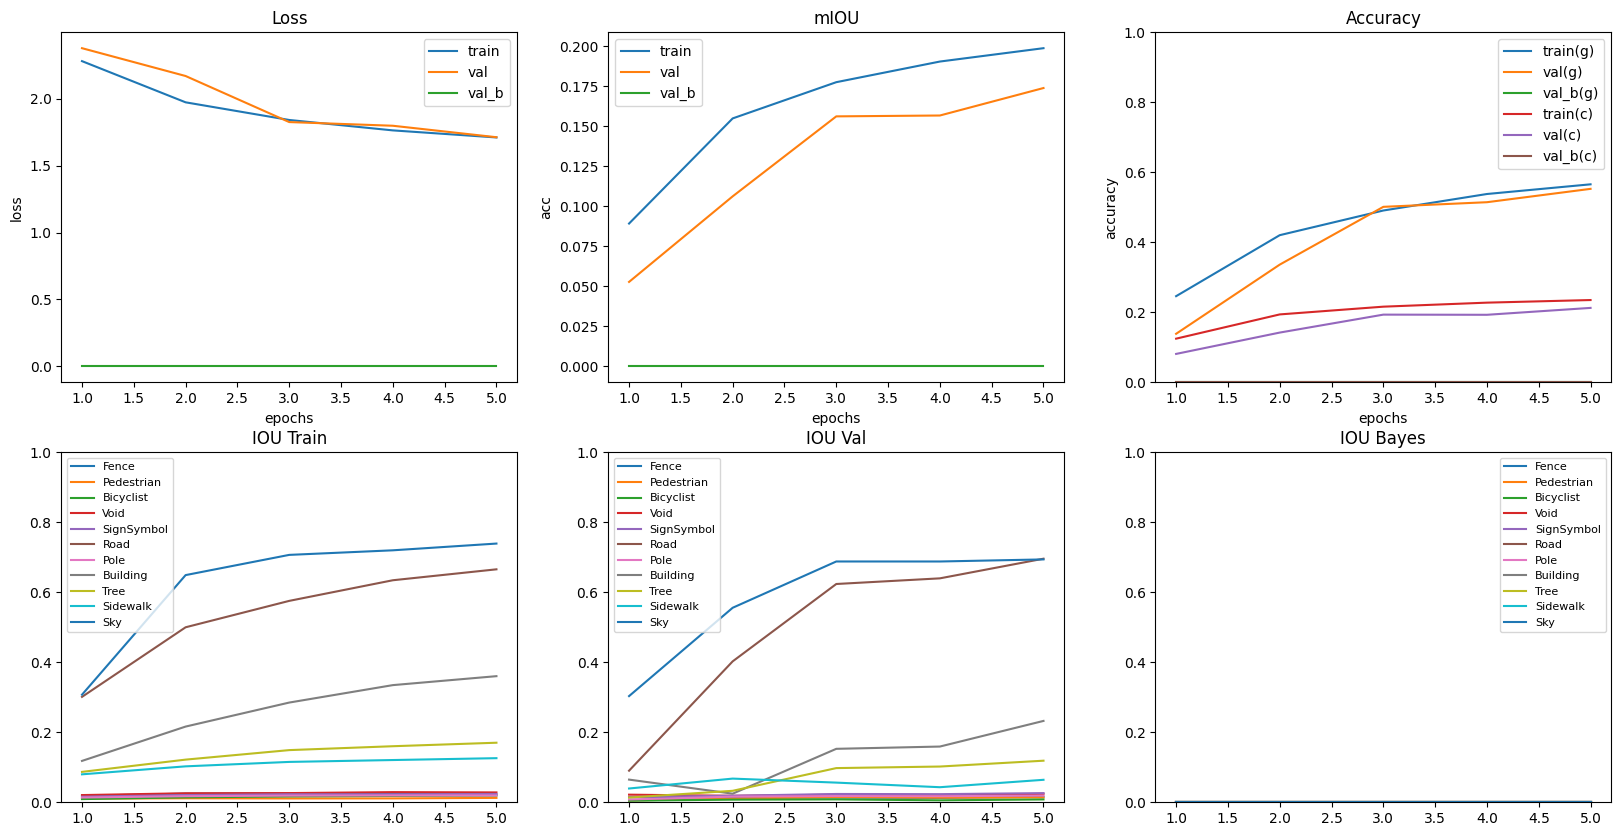

In [66]:
result_manager.plot()

In [ ]:
result_manager.save(save_plot=True)

## Qualitative performance

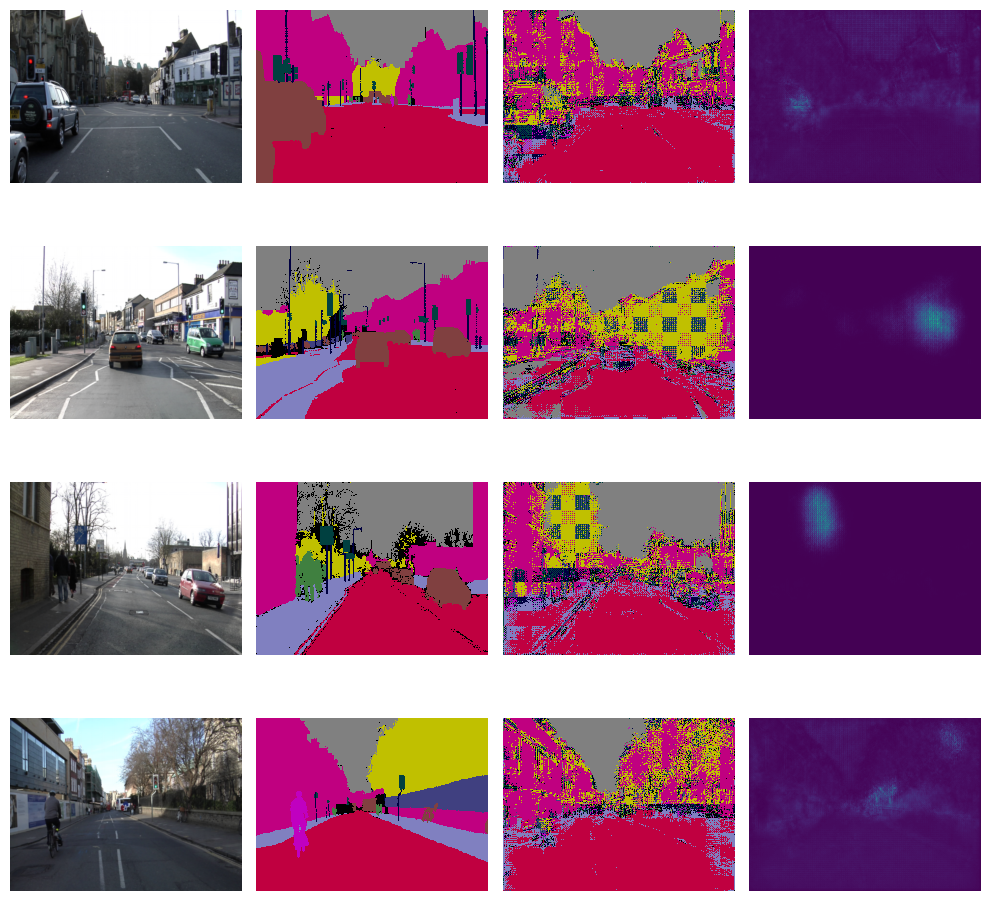

In [84]:
res = result_manager
net = res.training_manager.net
plt.figure(figsize=(10, 10))

k = 10

with torch.no_grad():
  for i in range(4):
    x, y = next(iter(dataloaders['val']))
    x, y = x[0], y[0]
    y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)
    # y_pred = bayes_eval(exp.net, x.unsqueeze(0), k)
    plt.subplot(4, 4, i*4+1)
    imshow_image(x)
    plt.axis('off')

    plt.subplot(4, 4, i*4+2)
    imshow_label(y)
    plt.axis('off')

    plt.subplot(4, 4, i*4+3)
    imshow_label(y_pred)
    plt.axis('off')

    plt.subplot(4, 4, i*4+4)
    plt.imshow(y_std.cpu())
    plt.axis('off')

  plt.tight_layout()

# plt.savefig(os.path.join(res.directory, 'qualitative.png'), dpi=200)
# print(f"saved to {os.path.join(EXPERIMENT_DIR, 'qualitative.png')}")